# Feed Optimization for Dairy Cows

This project uses Linear Programming to optimize the feed mix for dairy cows, aiming to minimize the cost while satisfying nutritional requirements. We use data from the USDA FoodData Central API for the nutrient composition of common feed ingredients.

## Project Steps:
1. Fetch nutrient data using the USDA API.
2. Handle missing data and replace with estimated averages.
3. Set up the Linear Programming (LP) model using `PuLP`.
4. Define the cost minimization objective and the nutritional constraints.
5. Solve the model and visualize the optimized feed mix.



## Step 1: Fetch Nutrient Data from USDA API
We will fetch the nutrient data for corn silage, soybean meal, barley, and hay using the USDA FoodData Central API.

In [7]:
import requests
import pandas as pd
import pulp
import matplotlib.pyplot as plt

# API Key and base URL for USDA FoodData Central
API_KEY = 'rN4YOtgn6oSLqzDxE4IpjluLd2sfxv7bWvdvjqza'
BASE_URL = 'https://api.nal.usda.gov/fdc/v1/foods/search'

# Define a list of feed ingredients to search for
feed_ingredients = ["corn silage", "soybean meal", "barley", "hay"]

# Fetch nutrient data for each feed ingredient
feed_data = []
for ingredient in feed_ingredients:
    params = {'api_key': API_KEY, 'query': ingredient, 'pageSize': 1}
    response = requests.get(BASE_URL, params=params)
    
    if response.status_code == 200:
        try:
            food_item = response.json()['foods'][0]
            nutrients = {nutrient['nutrientName']: nutrient['value'] for nutrient in food_item['foodNutrients']}
            feed_data.append({
                'Feed Ingredient': ingredient,
                'Protein (%)': nutrients.get('Protein', 0),
                'Fat (%)': nutrients.get('Total lipid (fat)', 0),
                'Fiber (%)': nutrients.get('Fiber, total dietary', 0),
                'Energy (kcal/kg)': nutrients.get('Energy', 0)
            })
        except (IndexError, KeyError):
            print(f"No nutrient data available for {ingredient}")
            continue

# Convert to DataFrame
feed_df = pd.DataFrame(feed_data)

# Display the data to verify
print(feed_df)


  Feed Ingredient  Protein (%)  Fat (%)  Fiber (%)  Energy (kcal/kg)
0     corn silage         0.84     0.21        0.5              44.0
1    soybean meal         0.00     0.00        0.0               0.0
2          barley         2.20     2.74        3.7             139.0
3             hay        11.50    23.10        7.7             500.0


## Step 2: Handle Missing Data
We replace any missing nutrient values (0s) with the average value from the dataset.

In [8]:
# Handle missing values by replacing with the mean
feed_df['Protein (%)'].replace(0, feed_df['Protein (%)'].mean(), inplace=True)
feed_df['Fat (%)'].replace(0, feed_df['Fat (%)'].mean(), inplace=True)
feed_df['Fiber (%)'].replace(0, feed_df['Fiber (%)'].mean(), inplace=True)
feed_df['Energy (kcal/kg)'].replace(0, feed_df['Energy (kcal/kg)'].mean(), inplace=True)

# Verify the updated nutrient data
print(feed_df)


  Feed Ingredient  Protein (%)  Fat (%)  Fiber (%)  Energy (kcal/kg)
0     corn silage        0.840   0.2100      0.500             44.00
1    soybean meal        3.635   6.5125      2.975            170.75
2          barley        2.200   2.7400      3.700            139.00
3             hay       11.500  23.1000      7.700            500.00


## Step 3: Define Nutritional Requirements and Prices
Here we define the minimum nutritional requirements for dairy cows and assign prices to each feed ingredient.

In [9]:
# Nutritional requirements (adjustable based on cow type)
protein_min = 16  # Increased protein requirement
fat_min = 4       # Increased fat requirement
fiber_min = 25    # Increased fiber requirement
energy_min = 3000 # Increased energy requirement

# Feed prices (in $ per kg)
feed_prices = {'corn silage': 0.15, 'soybean meal': 0.50, 'barley': 0.20, 'hay': 0.10}


## Step 4: Set Up the Linear Programming Model
We now set up the optimization problem using the PuLP library. The objective is to minimize the total cost of the feed while meeting the nutritional requirements.

In [10]:
# Define the LP problem
model = pulp.LpProblem("Feed_Optimization", pulp.LpMinimize)

# Decision variables: Proportion of each feed ingredient
feed_vars = pulp.LpVariable.dicts("Feed", feed_df['Feed Ingredient'], lowBound=0)

# Objective: Minimize cost
model += pulp.lpSum([feed_vars[i] * feed_prices[i] for i in feed_df['Feed Ingredient']])

# Constraints: Total feed = 100%
model += pulp.lpSum([feed_vars[i] for i in feed_df['Feed Ingredient']]) == 100

# Nutritional constraints
model += pulp.lpSum([feed_vars[i] * feed_df.loc[feed_df['Feed Ingredient'] == i, 'Protein (%)'].values[0] for i in feed_df['Feed Ingredient']]) >= protein_min
model += pulp.lpSum([feed_vars[i] * feed_df.loc[feed_df['Feed Ingredient'] == i, 'Fat (%)'].values[0] for i in feed_df['Feed Ingredient']]) >= fat_min
model += pulp.lpSum([feed_vars[i] * feed_df.loc[feed_df['Feed Ingredient'] == i, 'Fiber (%)'].values[0] for i in feed_df['Feed Ingredient']]) >= fiber_min
model += pulp.lpSum([feed_vars[i] * feed_df.loc[feed_df['Feed Ingredient'] == i, 'Energy (kcal/kg)'].values[0] for i in feed_df['Feed Ingredient']]) >= energy_min


## Step 5: Add Upper and Lower Bounds
To prevent over-reliance on hay or any single ingredient, we add upper and lower bounds for each feed ingredient

In [11]:
# Add upper and lower bounds to ensure balance in ingredients
for i in feed_df['Feed Ingredient']:
    if i != 'hay':  # Ensure other ingredients have at least 5%
        model += feed_vars[i] >= 5  # Minimum 5% for all other ingredients

model += feed_vars['hay'] <= 60  # Maximum 60% for hay


## Step 6: Solve the Model and Display Results
We now solve the optimization model and display the results, including the optimized feed mix and total cost.

In [12]:
# Solve the model
model.solve()

# Display results
for var in feed_vars:
    print(f"{var}: {feed_vars[var].varValue:.2f}%")

# Calculate total cost
total_cost = sum(feed_vars[i].varValue * feed_prices[i] for i in feed_df['Feed Ingredient'])
print(f"Total feed cost: ${total_cost:.2f} per kg")


corn silage: 30.00%
soybean meal: 5.00%
barley: 5.00%
hay: 60.00%
Total feed cost: $14.00 per kg


## Step 7: Visualize the Feed Mix
Finally, we visualize the optimized feed mix using a bar chart.

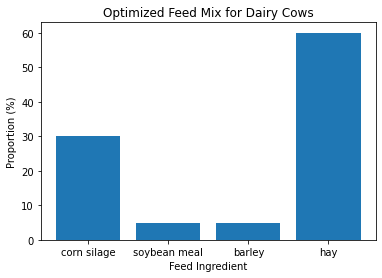

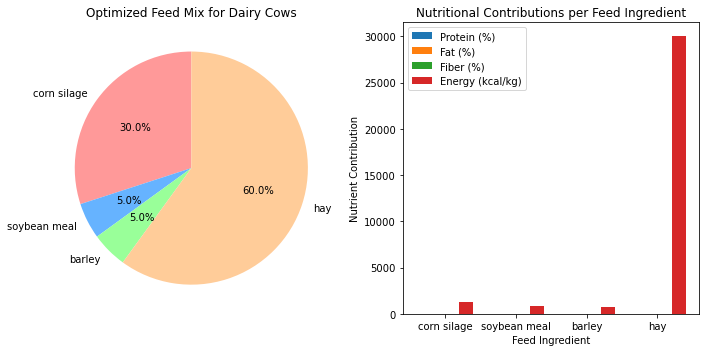

In [15]:
import matplotlib.pyplot as plt


# Visualize the feed mix
feed_solution = {var: feed_vars[var].varValue for var in feed_vars}
plt.bar(feed_solution.keys(), feed_solution.values())
plt.xlabel('Feed Ingredient')
plt.ylabel('Proportion (%)')
plt.title('Optimized Feed Mix for Dairy Cows')
plt.show()

# Extract the optimized feed mix
feed_solution = {var: feed_vars[var].varValue for var in feed_vars}

# Total feed mix pie chart
plt.figure(figsize=(10, 5))

# Pie chart for feed mix
plt.subplot(1, 2, 1)
plt.pie(feed_solution.values(), labels=feed_solution.keys(), autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Optimized Feed Mix for Dairy Cows')

# Bar chart for nutritional contributions
nutritional_contributions = {'Protein (%)': [], 'Fat (%)': [], 'Fiber (%)': [], 'Energy (kcal/kg)': []}

# Collect data for each nutrient contribution
for i in feed_df['Feed Ingredient']:
    nutritional_contributions['Protein (%)'].append(feed_vars[i].varValue * feed_df.loc[feed_df['Feed Ingredient'] == i, 'Protein (%)'].values[0] / 100)
    nutritional_contributions['Fat (%)'].append(feed_vars[i].varValue * feed_df.loc[feed_df['Feed Ingredient'] == i, 'Fat (%)'].values[0] / 100)
    nutritional_contributions['Fiber (%)'].append(feed_vars[i].varValue * feed_df.loc[feed_df['Feed Ingredient'] == i, 'Fiber (%)'].values[0] / 100)
    nutritional_contributions['Energy (kcal/kg)'].append(feed_vars[i].varValue * feed_df.loc[feed_df['Feed Ingredient'] == i, 'Energy (kcal/kg)'].values[0])

# Bar chart for nutritional contributions
plt.subplot(1, 2, 2)
width = 0.2
x = range(len(feed_df['Feed Ingredient']))

plt.bar(x, nutritional_contributions['Protein (%)'], width=width, label='Protein (%)')
plt.bar([p + width for p in x], nutritional_contributions['Fat (%)'], width=width, label='Fat (%)')
plt.bar([p + 2 * width for p in x], nutritional_contributions['Fiber (%)'], width=width, label='Fiber (%)')
plt.bar([p + 3 * width for p in x], nutritional_contributions['Energy (kcal/kg)'], width=width, label='Energy (kcal/kg)')

plt.xticks([p + 1.5 * width for p in x], feed_df['Feed Ingredient'])
plt.title('Nutritional Contributions per Feed Ingredient')
plt.xlabel('Feed Ingredient')
plt.ylabel('Nutrient Contribution')
plt.legend()

plt.tight_layout()
plt.show()


## Conclusion

This project demonstrates how to optimize the feed mix for dairy cows using Linear Programming, minimizing cost while meeting nutritional requirements. The use of real-world data from the USDA API and the balance of constraints ensures that the model produces a practical solution for the dairy industry.

## Next Steps:

             * Experiment with different cow types or nutritional requirements.
             * Explore different feed ingredients and adjust the cost structure.
             * Incorporate more advanced optimization techniques if needed